## 第10章 超解像

**共通モジュールの読み込み**

In [1]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras.layers import Add, Input, Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, UpSampling2D, Lambda

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**リスト10.1:低解像度の画像の生成**

In [5]:
def drop_resolution(x, scale=3.0):
    size = (x.shape[0], x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size, 3) # 3: PIL.Image.BICUBIC
    return img_to_array(small_img.resize(img.size, 3))

**リスト10.2:ジェネレータの定義**

In [6]:
def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
    for imgs in ImageDataGenerator().flow_from_directory( # ディレクトリへのパスを受け取り，拡張/正規化したデータのバッチを生成します
        directory=data_dir,
        classes=[mode],
        class_mode=None,
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle
    ): 
        x = np.array([
            drop_resolution(img, scale) for img in imgs
        ])
        yield x/255., imgs/255. # 0-1

**リスト10.3:data_generatorの利用**

In [7]:
DATA_DIR = 'data/chap10/'
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

train_data_generator = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)
test_x, test_y = next(
    data_generator(
        DATA_DIR,
        'test',
        batch_size=N_TEST_DATA, # 100
        shuffle=False
    )
)
# test_x (100, 200, 200, 3), test_y: (100, 200, 200, 3)

Found 100 images belonging to 1 classes.


**リスト10.4:SRCNNの定義**

In [10]:
model = Sequential()
model.add(Conv2D(
    filters=64,
    kernel_size=9, # 大きめの値
    padding='same',
    activation='relu',
    input_shape=(None, None, 3) # サイズとしてNoneも指定できる!
))
model.add(Conv2D(
    filters=32,
    kernel_size=1,
    padding='same',
    activation='relu'
))
model.add(Conv2D(
    filters=3,
    kernel_size=5,
    padding='same' # activationはなし
))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


**リスト10.5:ピーク信号対雑音比の定義**

In [11]:
def psnr(y_true, y_pred):
    return -10*K.log(
        K.mean(K.flatten((y_true - y_pred))**2)
    )/np.log(10)

**リスト10.6:PSNRをmetricsに指定して学習を実行**

In [12]:
model.compile(
    loss='mean_squared_error', # MSE
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y), # 検証用データのジェネレータ もしくは タプル (inputs, targets) or タプル (inputs, targets, sample_weights)
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE, # データにおけるユニークなサンプル数をバッチサイズで割った値
    epochs=50
)

# テストデータに対して適用
pred = model.predict(test_x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
Found 1000 images belonging to 1 classes.
31/31 [==============================]31/31 [==============================] - 53s 2s/step - loss: 0.0313 - psnr: 16.1675 - val_loss: 0.0146 - val_psnr: 18.3922

Epoch 2/50
31/31 [==============================]31/31 [==============================] - 7s 219ms/step - loss: 0.0109 - psnr: 19.6780 - val_loss: 0.0099 - val_psnr: 20.1043

Epoch 3/50
31/31 [==============================]31/31 [==============================] - 7s 210ms/step - loss: 0.0083 - psnr: 20.8619 - val_loss: 0.0080 - val_psnr: 21.0171

Epoch 4/50
31/31 [==============================]31/31 [==============================] - 7s 212ms/step - loss: 0.0069 - psnr: 21.6684 - val_loss: 0.0069 - val_psnr: 21.6678

Epoch 5/50
31/31 [==============================]31/31 [==============================] - 7s 212ms/step - loss: 0.0062 - psnr: 22.1190 - val_loss: 0.0065 - val_psnr: 21.9882

Epoch 6/50
3

31/31 [==============================]31/31 [==============================] - 7s 214ms/step - loss: 0.0038 - psnr: 24.2164 - val_loss: 0.0040 - val_psnr: 24.1022

Epoch 46/50
31/31 [==============================]31/31 [==============================] - 7s 216ms/step - loss: 0.0037 - psnr: 24.3564 - val_loss: 0.0040 - val_psnr: 24.0942

Epoch 47/50
31/31 [==============================]31/31 [==============================] - 7s 214ms/step - loss: 0.0036 - psnr: 24.5718 - val_loss: 0.0039 - val_psnr: 24.2484

Epoch 48/50
31/31 [==============================]31/31 [==============================] - 7s 215ms/step - loss: 0.0036 - psnr: 24.4612 - val_loss: 0.0039 - val_psnr: 24.2672

Epoch 49/50
31/31 [==============================]31/31 [==============================] - 7s 215ms/step - loss: 0.0039 - psnr: 24.2260 - val_loss: 0.0044 - val_psnr: 23.6713

Epoch 50/50
31/31 [==============================]31/31 [==============================] - 7s 215ms/step - loss: 0.0036 - psnr: 24.5

**図10.6:正解データ（実行環境によって対象となる画像は変わります）**

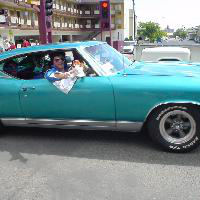

In [14]:
array_to_img(test_y[0])

**図10.7:入力データ**

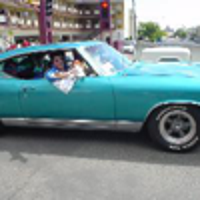

In [13]:
array_to_img(test_x[0])

**図10.8:予測結果**

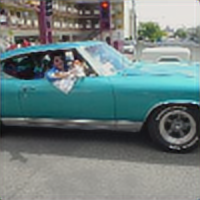

In [15]:
array_to_img(pred[0])

**リスト10.7:モデルの構築**

In [18]:
# 入力は任意のサイズで、3チャンネルの画像
inputs = Input((None, None, 3), dtype='float') # (200, 200, 3)

# Endoder
conv1 = Conv2D(64, 3, padding='same')(inputs) # (200, 200, 64)
conv1 = Conv2D(64, 3, padding='same')(conv1) # (200, 200, 64)

conv2 = Conv2D(64, 3, strides=2, padding='same')(conv1) # (100, 100, 64)
conv2 = Conv2D(64, 3, padding='same')(conv2)  # (100, 100, 64)

conv3 = Conv2D(64, 3, strides=2, padding='same')(conv2) # (50, 50, 64)
conv3 = Conv2D(64, 3, padding='same')(conv3) # (50, 50, 64)

# Decoder
deconv3 = Conv2DTranspose(64, 3, padding='same')(conv3) # (50, 50, 64)
deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv3) # (100, 100, 64)

# Add()レイヤーを使ってスキップコネクションを表現
merge2 = Add()([deconv3, conv2]) # (100, 100, 64) と　(100, 100, 64)
deconv2 = Conv2DTranspose(64, 3, padding='same')(merge2) # (100, 100, 64)
deconv2 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv2) # (200, 200, 64)

merge1 = Add()([deconv2, conv1]) # (200, 200, 64) と (200, 200, 64)
deconv1 = Conv2DTranspose(64, 3, padding='same')(merge1) # (200, 200, 64)
deconv1 = Conv2DTranspose(3, 3, padding='same')(deconv1) # (200, 200, 3)

output = Add()([deconv1, inputs]) # (200, 200, 3) と (200, 200, 3)

model = Model(inputs, output)

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, None, 6 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, None, None, 6 36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 

**PSNRをmetricsに指定して学習を実行**

In [20]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred = model.predict(test_x)

Epoch 1/50
31/31 [==============================]31/31 [==============================] - 33s 1s/step - loss: 0.0301 - psnr: 19.9160 - val_loss: 0.0058 - val_psnr: 22.4874

Epoch 2/50
31/31 [==============================]31/31 [==============================] - 29s 921ms/step - loss: 0.0053 - psnr: 22.8136 - val_loss: 0.0056 - val_psnr: 22.5852

Epoch 3/50
31/31 [==============================]31/31 [==============================] - 29s 920ms/step - loss: 0.0040 - psnr: 24.0185 - val_loss: 0.0041 - val_psnr: 24.0466

Epoch 4/50
31/31 [==============================]31/31 [==============================] - 29s 922ms/step - loss: 0.0039 - psnr: 24.1712 - val_loss: 0.0040 - val_psnr: 24.1115

Epoch 5/50
31/31 [==============================]31/31 [==============================] - 29s 921ms/step - loss: 0.0036 - psnr: 24.4954 - val_loss: 0.0040 - val_psnr: 24.1606

Epoch 6/50
31/31 [==============================]31/31 [==============================] - 29s 927ms/step - loss: 0.0038 - p

31/31 [==============================]31/31 [==============================] - 29s 941ms/step - loss: 0.0033 - psnr: 24.8730 - val_loss: 0.0037 - val_psnr: 24.4654

Epoch 48/50
31/31 [==============================]31/31 [==============================] - 29s 940ms/step - loss: 0.0033 - psnr: 24.8912 - val_loss: 0.0037 - val_psnr: 24.5416

Epoch 49/50
31/31 [==============================]31/31 [==============================] - 29s 940ms/step - loss: 0.0034 - psnr: 24.7865 - val_loss: 0.0037 - val_psnr: 24.5357

Epoch 50/50
31/31 [==============================]31/31 [==============================] - 29s 938ms/step - loss: 0.0032 - psnr: 25.0071 - val_loss: 0.0037 - val_psnr: 24.5448



In [ ]:
# SRCNN                              psnr: 24.5252 - val_loss: 0.0041 - val_psnr: 24.0140
# CAE+スキップコネクション  psnr: 25.0071 - val_loss: 0.0037 - val_psnr: 24.5448

**図10.10:正解データ**

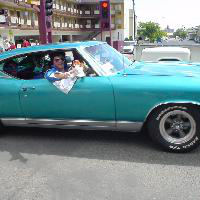

In [21]:
array_to_img(test_y[0])

**図10.11:入力データ**

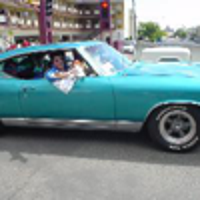

In [22]:
array_to_img(test_x[0])

**図10.12:予測結果**

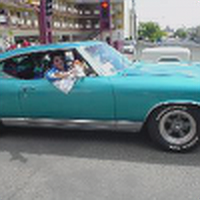

In [23]:
array_to_img(pred[0])